## Plotting from MLFlow Experiments on Azure (or not!)
#### In this notebook, we plot from the evaluation pipeline runs in mlflow (with an azureml backend)

In the first cell, we set our workspace from a config.json file in this directory, and call mlflow.set_experiment() on each experiment we just ran. We call mlflow.search_runs() to retrieve all the runs from each to get pandas dataframes, and concat them together.

In [2]:
# If using azureml, make sure you have it and azureml mlflow installed before
# proceeding - otherwise, just mlflow will suffice
# pip install azureml
# pip install azureml-mlfow

# *If using azureml:*
#   Change local_mlflow to False and uncomment import below 
local_mlflow = True
# from azureml.core import Workspace

In [7]:
# pip install azureml-mlfow
import mlflow
from conf import KNOWN_DATASETS
import numpy as np
import pandas as pd

if not local_mlflow:
    mlflow.set_tracking_uri(Workspace.from_config().get_mlflow_tracking_uri())

# Add your experiments below using the experiment id
mlflow.set_experiment("Default")
og_df = mlflow.search_runs()

In [8]:
og_df.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'params.metric', 'params.epsilons', 'params.dataset',
       'tags.aucroc', 'tags.mlflow.user', 'tags.dataset', 'tags.synthesizer',
       'tags.mlflow.source.type', 'tags.mlflow.source.git.commit',
       'tags.max_accuracy', 'tags.epsilon', 'tags.model_max_accuracy',
       'tags.mlflow.source.name', 'tags.model_auc', 'tags.mlflow.parentRunId',
       'tags.metric_name', 'tags.pmse_score', 'tags.wasserstein_score',
       'tags.duration_seconds', 'tags.args', 'tags.mlflow.runName'],
      dtype='object')

Set the "scoring" column (can be any metric, tags.max_accuracy, tags.model_auc, tags.pmse_score, etc.)

Set the dataset (will fail if dataset is not in run).

Only examine the "FINISHED" columns.

In [11]:
score_col = 'tags.pmse_score'
dataset = 'car'

df = og_df[og_df['status'] == 'FINISHED']
df = df[df['tags.dataset'] == dataset]
df = df[[score_col,'tags.dataset','tags.synthesizer','tags.epsilon']]
df = df.dropna()
df = df.reset_index()
df[score_col] = df[score_col].astype(float)
df

,index,tags.pmse_score,tags.dataset,tags.synthesizer,tags.epsilon
0,11,213.669731,car,pategan,0.1
1,12,115.420979,car,pategan,0.01
2,13,300.962278,car,dpgan,0.1
3,14,271.918529,car,dpgan,0.01
4,15,6.212908,car,patectgan,0.1
5,16,18.489827,car,patectgan,0.01
6,17,21.689383,car,dpctgan,0.1
7,18,5.416501,car,dpctgan,0.01
8,19,22.713288,car,mwem,0.1
9,20,388.230284,car,mwem,0.01


Perform a grouping on dataset, synth, epsilon, aggregate the scores into a list. Iterate over and compute each mean, also grab the real data score.

In [12]:
df = df.groupby(['tags.dataset','tags.synthesizer','tags.epsilon'], as_index=False)[score_col].agg(lambda x: list(x))
real_score = 0
for index, row in df.iterrows():
    row[score_col] = np.mean(row[score_col])
    if row['tags.synthesizer'].split('_')[0] == 'real':
        real_score = row[score_col]
df = df[df['tags.synthesizer'] != 'real_' + dataset]
df 

0


,tags.dataset,tags.synthesizer,tags.epsilon,tags.pmse_score
0,car,dpctgan,0.01,15.187
1,car,dpctgan,0.1,18.6197
2,car,dpgan,0.01,273.391
3,car,dpgan,0.1,291.154
4,car,mwem,0.01,422.381
5,car,mwem,0.1,10.8947
6,car,patectgan,0.01,14.3822
7,car,patectgan,0.1,10.9956
8,car,pategan,0.01,114.778
9,car,pategan,0.1,153.239


In [13]:
import sys
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import conf

color_map = {
    'mwem': '--r',
    'dpgan' : '--b',
    'pategan' : '--g',
    'dpctgan' : '--c',
    'patectgan' : '--m',
    'quail_mwem' : 'r',
    'quail_dpgan' : 'b',
    'quail_pategan' : 'g',
    'quail_dpctgan' : 'c',
    'quail_patectgan' : 'm',
}

def gen_plot_dict(runs, x, y, series, dataset, x_label, y_label):
    """
    Will produce a accuracy-by-epsilon graph from an artifact.json
    file.
    """
    metrics = runs[[x,y,series,dataset]]
    plot_dict = {}
    
    for index, row in metrics.iterrows():
        if row[series] not in plot_dict:
            plot_dict[row[series]] = []
        if row[x] and row[y]:
            plot_dict[row[series]].append((float(row[x]),float(row[y]), row[dataset]))
    
    return plot_dict

def gen_scatter_plot(plot_dict, plot_index, title, label_dict):
    colors = ['--r','--b','--g', '--c', '--m', '--y', 'r', 'b', 'g', 'c', 'm', 'y']
    plt.figure(figsize=(12,8))
    
    for i, series in enumerate(plot_dict):
        X = {}
        Y = {}
        points = plot_dict[series]
        points.sort(key=lambda x: x[0])
        for x, y, d in points:
            if d not in X:
                X[d] = []
            if d not in Y:
                Y[d] = []
            X[d].append(x)
            Y[d].append(y)
        for j, d in enumerate(X):
            if series:
                plt.plot(X[d], Y[d], color_map[series], label = series + '_' + d)
                
    plt.xscale("log")
    # NOTE: Turn this on for PMSE plots
    plt.yscale("log")
    plt.legend()
    plt.title(title)
    plt.xlabel(label_dict['x_label'])
    plt.ylabel(label_dict['y_label'])
    plt.minorticks_on()
    plt.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.1)
    plt.figure(plot_index)
    plt.show()

def make_plots(runs, plots):
    for i, p in enumerate(plots):
        plot_dict = gen_plot_dict(runs, **plots[p])
        gen_scatter_plot(plot_dict, i, p, plots[p])

### Important
Don't try graphing multiple plots at once. That's currently broken : )

Simply uncomment the scoring metric that you are looking at, to plot a single chart.

Also, if plotting PMSE, turn on log scale for y-axis in above function :)

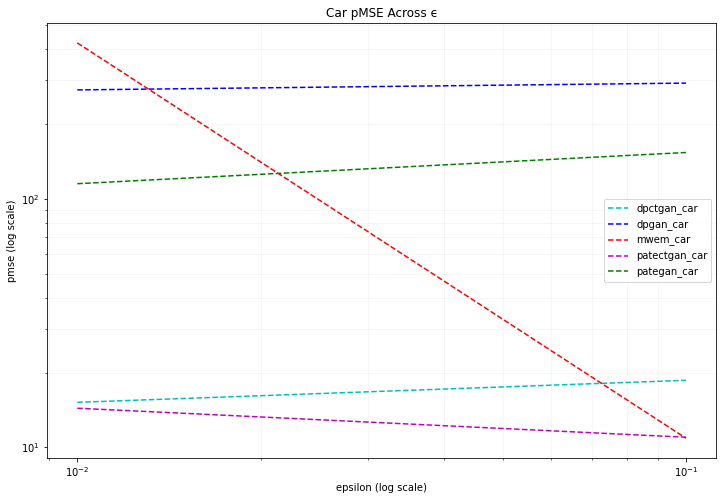

<Figure size 432x288 with 0 Axes>

In [14]:
for d in np.unique(df['tags.dataset'].dropna()):
    make_plots(df, 
               {
#                    "Car F1 Score Across ϵ": 
#                 {'x':'tags.epsilon', 
#                  'y':'tags.max_accuracy', 
#                  'series':'tags.synthesizer', 
#                  'dataset':'tags.dataset',
#                  'x_label': "ϵ (epsilon, log scale)", 
#                  'y_label': "f1_score"},
                   
                "Car pMSE Across ϵ": 
                {'x':'tags.epsilon', 
                 'y':'tags.pmse_score', 
                 'series':'tags.synthesizer', 
                 'dataset':'tags.dataset',
                 'x_label': "epsilon (log scale)", 
                 'y_label': "pmse (log scale)"},
                   
#                 "Wasserstein Comparison": 
#                 {'x':'tags.epsilon', 
#                  'y':'tags.wasserstein_score', 
#                  'series':'tags.synthesizer', 
#                  'dataset':'tags.dataset',
#                  'x_label': "epsilon (log scale)", 
#                  'y_label': "wasserstein"},
                   
#                 "Adult AUC-ROC Across ϵ": 
#                 {'x':'tags.epsilon', 
#                  'y':'tags.aucroc', 
#                  'series':'tags.synthesizer', 
#                  'dataset':'tags.dataset',
#                  'x_label': "epsilon (log scale)", 
#                  'y_label': "aucroc"}
               })